# Investigate Opaque clouds in the Arctic

Reviewers want hard data showing that CALIOP penetrates to the ground or at least through the liquid cloud top of Arctic mixed-phase clouds.

I will use the new CALIOP observations (Guzman et al. JGRA, 2007) of opaque cloud fraction and the height of opacity (z_OPAQ) to try and respond to these concerns.

In [56]:
import sys
# Add common resources folder to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, re
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png, average_and_wrap, mute_ax, add_map_features,
    polarCentral_set_latlim
    )

from classes import SatComp_Metric, CT_SLF_Metric
from collections import deque
%matplotlib inline

import dask
import glob

In [2]:
obs_dir = '/mnt/mcc-ns9600k/jonahks/GOCCP_data/2Ddata/'

In [3]:
opaq_files = glob.glob('%s/20??/Map_OPAQ*.nc' % obs_dir)
opaq_files.sort()

In [4]:
opaq_ds = xr.open_mfdataset(opaq_files)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/xarray/backends/api.py:933: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In [59]:
# opaq_ds_subset = opaq_ds.sel(time=slice('2009-06-01','2013-05-31'),latitude=slice(59,90))
opaq_ds_subset = opaq_ds.sel(time=slice('2009-06-01','2013-05-31'),latitude=slice(66,90))
opaq_ds_subset = opaq_ds_subset.rename({'latitude':'lat','longitude':'lon'})

#### Plot thin and opaque cloud fraction with penetration depth for all months.

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.p

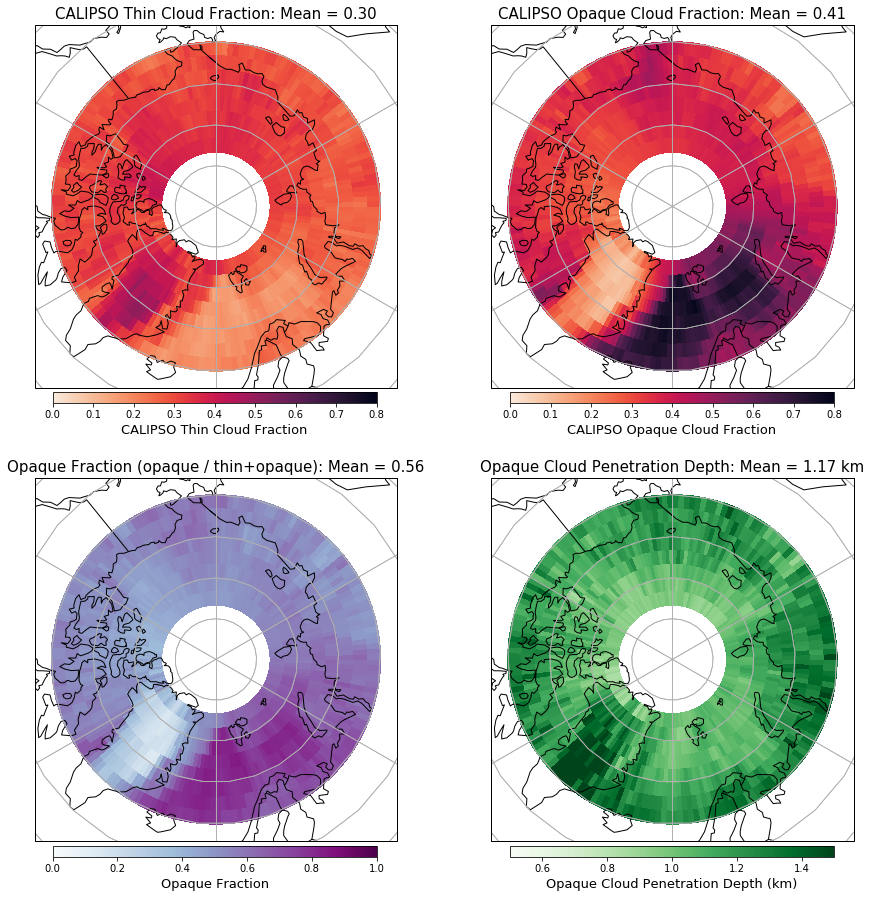

In [149]:
fig, axes = sp_map(nrows=2, ncols=2,
                    projection=ccrs.NorthPolarStereo(), figsize=[15,15])
axes = axes.flat

plt.subplots_adjust(hspace=0.25)

cltcalipso_thin_Tavg = add_weights(opaq_ds_subset['cltcalipso_thin'].mean('time'))
cltcalipso_opaque_Tavg = add_weights(opaq_ds_subset['cltcalipso_opaque'].mean('time'))
calipso_opaque_frac = cltcalipso_opaque_Tavg / (cltcalipso_opaque_Tavg + cltcalipso_thin_Tavg)
caliop_depth = add_weights((opaq_ds_subset['cltcalipso_opaque_z'] - opaq_ds_subset['zopaque']).mean('time'))

# Calculate Arctic Averages:
cltcalipso_thin_ArcAvg = masked_average(cltcalipso_thin_Tavg,
                                        weights=cltcalipso_thin_Tavg['cell_weight'],
                                       mask=cltcalipso_thin_Tavg['lat']<66)
cltcalipso_opaque_ArcAvg = masked_average(cltcalipso_opaque_Tavg,
                                        weights=cltcalipso_opaque_Tavg['cell_weight'],
                                       mask=cltcalipso_opaque_Tavg['lat']<66)
calipso_opaque_frac_ArcAvg = masked_average(calipso_opaque_frac,
                                        weights=calipso_opaque_frac['cell_weight'],
                                       mask=calipso_opaque_frac['lat']<66)
caliop_depth_ArcAvg = masked_average(caliop_depth,
                                        weights=caliop_depth['cell_weight'],
                                       mask=caliop_depth['lat']<66)

im0 = cltcalipso_thin_Tavg.plot(ax=axes[0],cmap=sns.cm.rocket_r,transform=ccrs.PlateCarree(),
                              add_colorbar=False, robust=True,vmin=0,vmax=0.8)
axes[0].set_title('CALIPSO Thin Cloud Fraction: Mean = %.2f' % cltcalipso_thin_ArcAvg,fontsize=15)
cax0 = fig.add_axes([0.15,0.53,0.3,0.01])
cbar0 = plt.colorbar(im0,cax=cax0,orientation='horizontal')
cbar0.set_label(label='CALIPSO Thin Cloud Fraction',fontsize=13)

im1 = cltcalipso_opaque_Tavg.plot(ax=axes[1],cmap=sns.cm.rocket_r,transform=ccrs.PlateCarree(),
                              add_colorbar=False, robust=True,vmin=0,vmax=0.8)
axes[1].set_title('CALIPSO Opaque Cloud Fraction: Mean = %.2f' % cltcalipso_opaque_ArcAvg,fontsize=15)
cax1 = fig.add_axes([0.5735,0.53,0.3,0.01])
cbar1 = plt.colorbar(im1,cax=cax1,orientation='horizontal')
cbar1.set_label(label='CALIPSO Opaque Cloud Fraction',fontsize=13)


im2 = calipso_opaque_frac.plot(ax=axes[2],cmap='BuPu',transform=ccrs.PlateCarree(),
                              add_colorbar=False, robust=True,vmin=0,vmax=1.0)
axes[2].set_title('Opaque Fraction (opaque / thin+opaque): Mean = %.2f' % calipso_opaque_frac_ArcAvg,fontsize=15)
cax2 = fig.add_axes([0.15,0.11,0.3,0.01])
cbar2 = plt.colorbar(im2,cax=cax2,orientation='horizontal')
cbar2.set_label(label='Opaque Fraction',fontsize=13)

# test_palette = sns.cubehelix_palette(9,0.3,0.8,0.6,0.8,0.8,0.2,as_cmap=True)
im3 = caliop_depth.plot(ax=axes[3],transform=ccrs.PlateCarree(),cmap="Greens",
                              add_colorbar=False,robust=False,vmin=0.5,vmax=1.5)
axes[3].set_title('Opaque Cloud Penetration Depth: Mean = %.2f km' % caliop_depth_ArcAvg,fontsize=15)
cax3 = fig.add_axes([0.5735,0.11,0.3,0.01])
cbar3 = plt.colorbar(im3,cax=cax3,orientation='horizontal')
cbar3.set_label(label='Opaque Cloud Penetration Depth (km)',fontsize=13)

# opaqcld_z = opaq_ds_subset['cltcalipso_opaque_z'].mean(dim='time')
# im4 = opaqcld_z.plot(ax=axes[4],transform=ccrs.PlateCarree(),
#                               add_colorbar=True, robust=True)
# axes[4].set_title('Height of opaque clouds (km)')

# z_opaq = opaq_ds_subset['zopaque'].mean(dim='time')
# im5 = z_opaq.plot(ax=axes[5],transform=ccrs.PlateCarree(),
#                               add_colorbar=True, robust=True)
# axes[5].set_title('Height of opacity (opaque clouds) (km)')

lat_lims = [59,90]
for _ax in axes:
    add_map_features(_ax)
#     polarCentral_set_latlim(lat_lims, _ax)

# plt.tight_layout()

In [155]:
to_png(fig,'CALIOP_depth_4panel')

## Plot thin and opaque cloud fraction with penetration depth for each season.

#### Calculate season means for each variable, weighting by month length

In [118]:
cltcalipso_thin_Smean = add_weights(season_mean(opaq_ds_subset['cltcalipso_thin']))
cltcalipso_opaque_Smean = add_weights(season_mean(opaq_ds_subset['cltcalipso_opaque']))
calipso_opaque_frac_Smean = cltcalipso_opaque_Smean / (cltcalipso_opaque_Smean + cltcalipso_thin_Smean)
caliop_depth_Smean = add_weights(season_mean((opaq_ds_subset['cltcalipso_opaque_z'] - opaq_ds_subset['zopaque'])))

#### Separate seasons

In [122]:
cltcalipso_thin_DJF = cltcalipso_thin_Smean.sel(season='DJF')
cltcalipso_opaque_DJF = cltcalipso_opaque_Smean.sel(season='DJF')
calipso_opaque_frac_DJF = calipso_opaque_frac_Smean.sel(season='DJF')
caliop_depth_DJF = caliop_depth_Smean.sel(season='DJF')

In [124]:
cltcalipso_thin_MAM = cltcalipso_thin_Smean.sel(season='MAM')
cltcalipso_opaque_MAM = cltcalipso_opaque_Smean.sel(season='MAM')
calipso_opaque_frac_MAM = calipso_opaque_frac_Smean.sel(season='MAM')
caliop_depth_MAM = caliop_depth_Smean.sel(season='MAM')

In [125]:
cltcalipso_thin_JJA = cltcalipso_thin_Smean.sel(season='JJA')
cltcalipso_opaque_JJA = cltcalipso_opaque_Smean.sel(season='JJA')
calipso_opaque_frac_JJA = calipso_opaque_frac_Smean.sel(season='JJA')
caliop_depth_JJA = caliop_depth_Smean.sel(season='JJA')

In [126]:
cltcalipso_thin_SON = cltcalipso_thin_Smean.sel(season='SON')
cltcalipso_opaque_SON = cltcalipso_opaque_Smean.sel(season='SON')
calipso_opaque_frac_SON = calipso_opaque_frac_Smean.sel(season='SON')
caliop_depth_SON = caliop_depth_Smean.sel(season='SON')

#### DJF

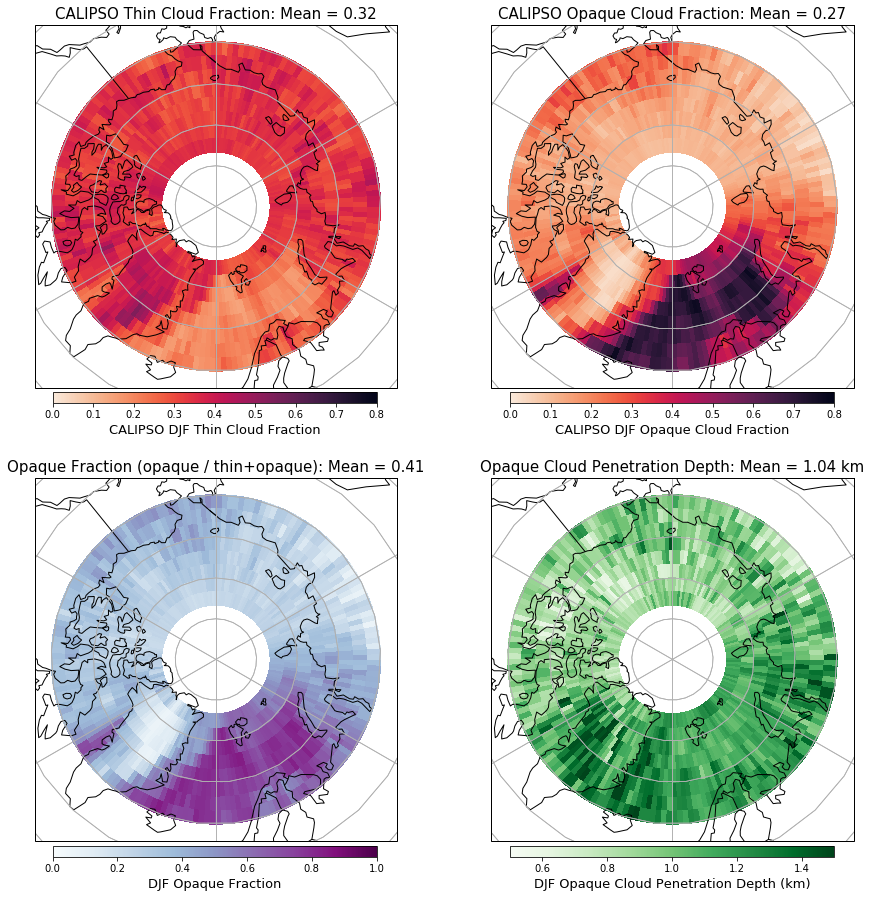

In [150]:
fig_DJF, axes = sp_map(nrows=2, ncols=2,
                    projection=ccrs.NorthPolarStereo(), figsize=[15,15])
axes = axes.flat

plt.subplots_adjust(hspace=0.25)

# Calculate Arctic Averages:
cltcalipso_thin_ArcAvg = masked_average(cltcalipso_thin_DJF,
                                        weights=cltcalipso_thin_DJF['cell_weight'],
                                        mask=cltcalipso_thin_DJF['lat']<66)
cltcalipso_opaque_ArcAvg = masked_average(cltcalipso_opaque_DJF,
                                        weights=cltcalipso_opaque_DJF['cell_weight'],
                                        mask=cltcalipso_opaque_DJF['lat']<66)
calipso_opaque_frac_ArcAvg = masked_average(calipso_opaque_frac_DJF,
                                        weights=calipso_opaque_frac_DJF['cell_weight'],
                                        mask=calipso_opaque_frac_DJF['lat']<66)
caliop_depth_ArcAvg = masked_average(caliop_depth_DJF,
                                        weights=caliop_depth_DJF['cell_weight'],
                                        mask=caliop_depth_DJF['lat']<66)

im0 = cltcalipso_thin_DJF.plot(ax=axes[0],cmap=sns.cm.rocket_r,transform=ccrs.PlateCarree(),
                              add_colorbar=False, robust=True,vmin=0,vmax=0.8)
axes[0].set_title('CALIPSO Thin Cloud Fraction: Mean = %.2f' % cltcalipso_thin_ArcAvg,fontsize=15)
cax0 = fig_DJF.add_axes([0.15,0.53,0.3,0.01])
cbar0 = plt.colorbar(im0,cax=cax0,orientation='horizontal')
cbar0.set_label(label='CALIPSO DJF Thin Cloud Fraction',fontsize=13)

im1 = cltcalipso_opaque_DJF.plot(ax=axes[1],cmap=sns.cm.rocket_r,transform=ccrs.PlateCarree(),
                              add_colorbar=False, robust=True,vmin=0,vmax=0.8)
axes[1].set_title('CALIPSO Opaque Cloud Fraction: Mean = %.2f' % cltcalipso_opaque_ArcAvg,fontsize=15)
cax1 = fig_DJF.add_axes([0.5735,0.53,0.3,0.01])
cbar1 = plt.colorbar(im1,cax=cax1,orientation='horizontal')
cbar1.set_label(label='CALIPSO DJF Opaque Cloud Fraction',fontsize=13)

im2 = calipso_opaque_frac_DJF.plot(ax=axes[2],cmap='BuPu',transform=ccrs.PlateCarree(),
                              add_colorbar=False, robust=True,vmin=0,vmax=1.0)
axes[2].set_title('Opaque Fraction (opaque / thin+opaque): Mean = %.2f' % calipso_opaque_frac_ArcAvg,fontsize=15)
cax2 = fig_DJF.add_axes([0.15,0.11,0.3,0.01])
cbar2 = plt.colorbar(im2,cax=cax2,orientation='horizontal')
cbar2.set_label(label='DJF Opaque Fraction',fontsize=13)

im3 = caliop_depth_DJF.plot(ax=axes[3],transform=ccrs.PlateCarree(),cmap="Greens",
                              add_colorbar=False,robust=False,extend='neither',vmin=0.5,vmax=1.5)
axes[3].set_title('Opaque Cloud Penetration Depth: Mean = %.2f km' % caliop_depth_ArcAvg,fontsize=15)
cax3 = fig_DJF.add_axes([0.5735,0.11,0.3,0.01])
cbar3 = plt.colorbar(im3,cax=cax3,orientation='horizontal')
cbar3.set_label(label='DJF Opaque Cloud Penetration Depth (km)',fontsize=13)


lat_lims = [59,90]
for _ax in axes:
    add_map_features(_ax)
#     polarCentral_set_latlim(lat_lims, _ax)

# plt.tight_layout()

In [157]:
to_png(fig_DJF,'CALIOP_depth_4panel_DJF')

#### MAM

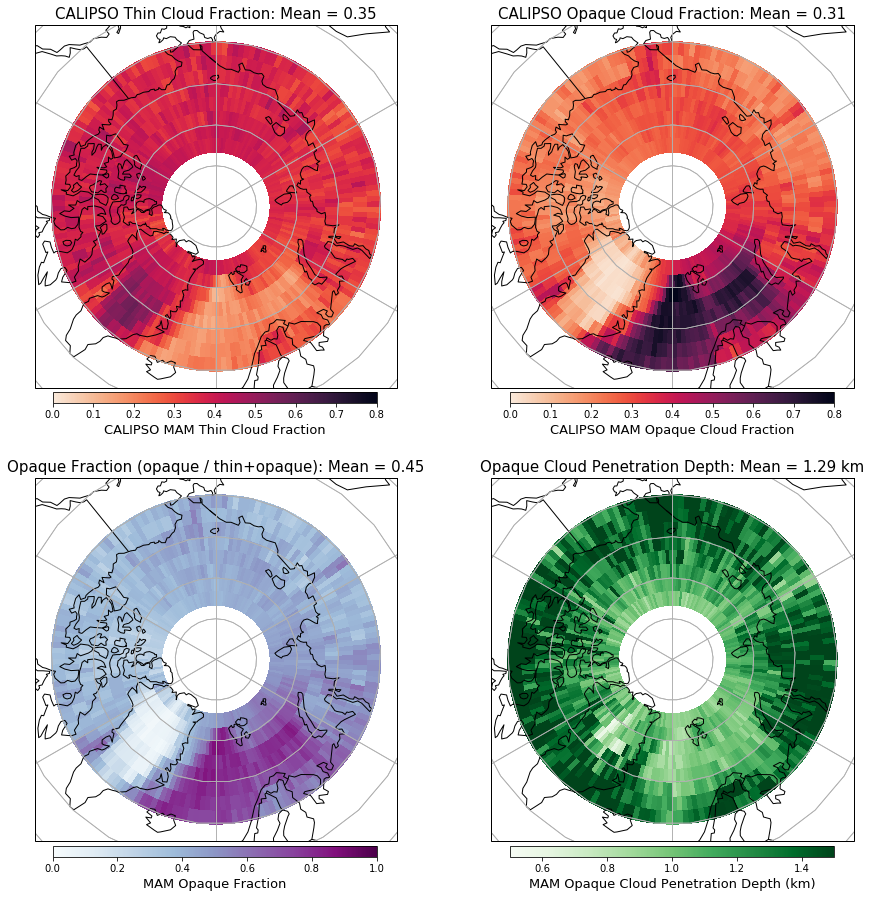

In [151]:
fig_MAM, axes = sp_map(nrows=2, ncols=2,
                    projection=ccrs.NorthPolarStereo(), figsize=[15,15])
axes = axes.flat

plt.subplots_adjust(hspace=0.25)

# Calculate Arctic Averages:
cltcalipso_thin_ArcAvg = masked_average(cltcalipso_thin_MAM,
                                        weights=cltcalipso_thin_MAM['cell_weight'],
                                        mask=cltcalipso_thin_MAM['lat']<66)
cltcalipso_opaque_ArcAvg = masked_average(cltcalipso_opaque_MAM,
                                        weights=cltcalipso_opaque_MAM['cell_weight'],
                                        mask=cltcalipso_opaque_MAM['lat']<66)
calipso_opaque_frac_ArcAvg = masked_average(calipso_opaque_frac_MAM,
                                        weights=calipso_opaque_frac_MAM['cell_weight'],
                                        mask=calipso_opaque_frac_MAM['lat']<66)
caliop_depth_ArcAvg = masked_average(caliop_depth_MAM,
                                        weights=caliop_depth_MAM['cell_weight'],
                                        mask=caliop_depth_MAM['lat']<66)

im0 = cltcalipso_thin_MAM.plot(ax=axes[0],cmap=sns.cm.rocket_r,transform=ccrs.PlateCarree(),
                              add_colorbar=False, robust=True,vmin=0,vmax=0.8)
axes[0].set_title('CALIPSO Thin Cloud Fraction: Mean = %.2f' % cltcalipso_thin_ArcAvg,fontsize=15)
cax0 = fig_MAM.add_axes([0.15,0.53,0.3,0.01])
cbar0 = plt.colorbar(im0,cax=cax0,orientation='horizontal')
cbar0.set_label(label='CALIPSO MAM Thin Cloud Fraction',fontsize=13)

im1 = cltcalipso_opaque_MAM.plot(ax=axes[1],cmap=sns.cm.rocket_r,transform=ccrs.PlateCarree(),
                              add_colorbar=False, robust=True,vmin=0,vmax=0.8)
axes[1].set_title('CALIPSO Opaque Cloud Fraction: Mean = %.2f' % cltcalipso_opaque_ArcAvg,fontsize=15)
cax1 = fig_MAM.add_axes([0.5735,0.53,0.3,0.01])
cbar1 = plt.colorbar(im1,cax=cax1,orientation='horizontal')
cbar1.set_label(label='CALIPSO MAM Opaque Cloud Fraction',fontsize=13)

im2 = calipso_opaque_frac_MAM.plot(ax=axes[2],cmap='BuPu',transform=ccrs.PlateCarree(),
                              add_colorbar=False, robust=True,vmin=0,vmax=1.0)
axes[2].set_title('Opaque Fraction (opaque / thin+opaque): Mean = %.2f' % calipso_opaque_frac_ArcAvg,fontsize=15)
cax2 = fig_MAM.add_axes([0.15,0.11,0.3,0.01])
cbar2 = plt.colorbar(im2,cax=cax2,orientation='horizontal')
cbar2.set_label(label='MAM Opaque Fraction',fontsize=13)

im3 = caliop_depth_MAM.plot(ax=axes[3],transform=ccrs.PlateCarree(),cmap="Greens",
                              add_colorbar=False,robust=False,extend='neither',vmin=0.5,vmax=1.5)
axes[3].set_title('Opaque Cloud Penetration Depth: Mean = %.2f km' % caliop_depth_ArcAvg,fontsize=15)
cax3 = fig_MAM.add_axes([0.5735,0.11,0.3,0.01])
cbar3 = plt.colorbar(im3,cax=cax3,orientation='horizontal')
cbar3.set_label(label='MAM Opaque Cloud Penetration Depth (km)',fontsize=13)


lat_lims = [59,90]
for _ax in axes:
    add_map_features(_ax)
#     polarCentral_set_latlim(lat_lims, _ax)

# plt.tight_layout()

In [159]:
to_png(fig_MAM,'CALIOP_depth_4panel_MAM')

#### JJA

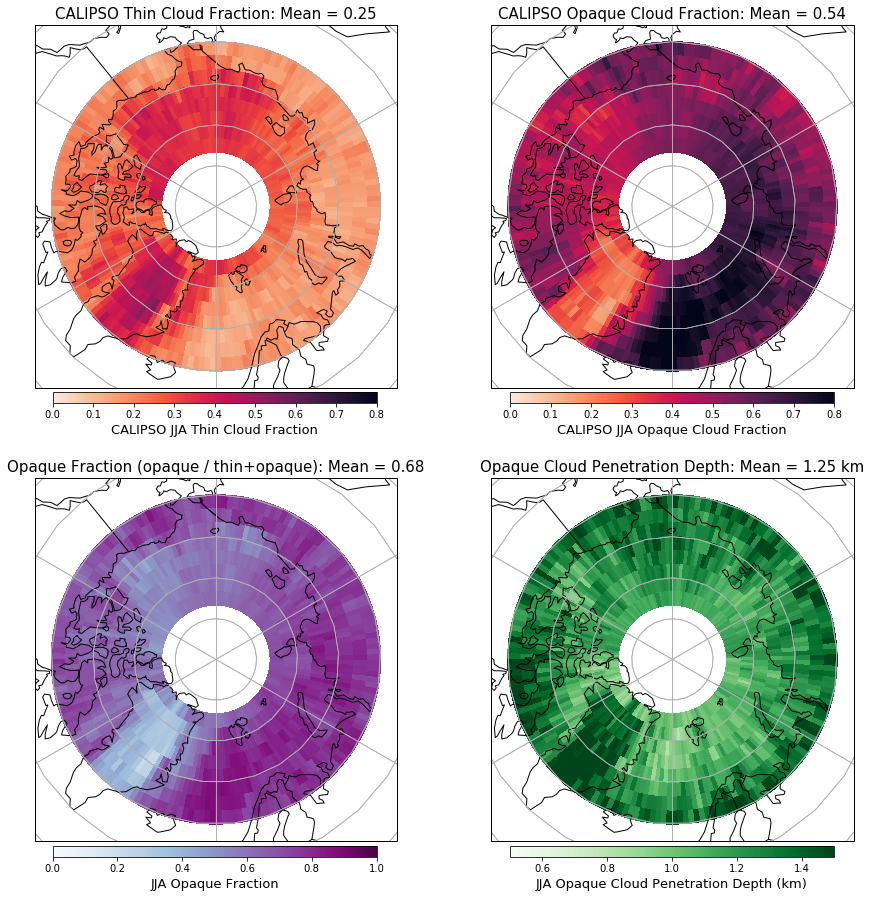

In [152]:
fig_JJA, axes = sp_map(nrows=2, ncols=2,
                    projection=ccrs.NorthPolarStereo(), figsize=[15,15])
axes = axes.flat

plt.subplots_adjust(hspace=0.25)

# Calculate Arctic Averages:
cltcalipso_thin_ArcAvg = masked_average(cltcalipso_thin_JJA,
                                        weights=cltcalipso_thin_JJA['cell_weight'],
                                        mask=cltcalipso_thin_JJA['lat']<66)
cltcalipso_opaque_ArcAvg = masked_average(cltcalipso_opaque_JJA,
                                        weights=cltcalipso_opaque_JJA['cell_weight'],
                                        mask=cltcalipso_opaque_JJA['lat']<66)
calipso_opaque_frac_ArcAvg = masked_average(calipso_opaque_frac_JJA,
                                        weights=calipso_opaque_frac_JJA['cell_weight'],
                                        mask=calipso_opaque_frac_JJA['lat']<66)
caliop_depth_ArcAvg = masked_average(caliop_depth_JJA,
                                        weights=caliop_depth_JJA['cell_weight'],
                                        mask=caliop_depth_JJA['lat']<66)

im0 = cltcalipso_thin_JJA.plot(ax=axes[0],cmap=sns.cm.rocket_r,transform=ccrs.PlateCarree(),
                              add_colorbar=False, robust=True,vmin=0,vmax=0.8)
axes[0].set_title('CALIPSO Thin Cloud Fraction: Mean = %.2f' % cltcalipso_thin_ArcAvg,fontsize=15)
cax0 = fig_JJA.add_axes([0.15,0.53,0.3,0.01])
cbar0 = plt.colorbar(im0,cax=cax0,orientation='horizontal')
cbar0.set_label(label='CALIPSO JJA Thin Cloud Fraction',fontsize=13)

im1 = cltcalipso_opaque_JJA.plot(ax=axes[1],cmap=sns.cm.rocket_r,transform=ccrs.PlateCarree(),
                              add_colorbar=False, robust=True,vmin=0,vmax=0.8)
axes[1].set_title('CALIPSO Opaque Cloud Fraction: Mean = %.2f' % cltcalipso_opaque_ArcAvg,fontsize=15)
cax1 = fig_JJA.add_axes([0.5735,0.53,0.3,0.01])
cbar1 = plt.colorbar(im1,cax=cax1,orientation='horizontal')
cbar1.set_label(label='CALIPSO JJA Opaque Cloud Fraction',fontsize=13)

im2 = calipso_opaque_frac_JJA.plot(ax=axes[2],cmap='BuPu',transform=ccrs.PlateCarree(),
                              add_colorbar=False, robust=True,vmin=0,vmax=1.0)
axes[2].set_title('Opaque Fraction (opaque / thin+opaque): Mean = %.2f' % calipso_opaque_frac_ArcAvg,fontsize=15)
cax2 = fig_JJA.add_axes([0.15,0.11,0.3,0.01])
cbar2 = plt.colorbar(im2,cax=cax2,label='JJA Opaque Fraction',orientation='horizontal')
cbar2.set_label(label='JJA Opaque Fraction',fontsize=13)

im3 = caliop_depth_JJA.plot(ax=axes[3],transform=ccrs.PlateCarree(),cmap="Greens",
                              add_colorbar=False,robust=False,extend='neither',vmin=0.5,vmax=1.5)
axes[3].set_title('Opaque Cloud Penetration Depth: Mean = %.2f km' % caliop_depth_ArcAvg,fontsize=15)
cax3 = fig_JJA.add_axes([0.5735,0.11,0.3,0.01])
cbar3 = plt.colorbar(im3,cax=cax3,orientation='horizontal')
cbar3.set_label(label='JJA Opaque Cloud Penetration Depth (km)',fontsize=13)


lat_lims = [59,90]
for _ax in axes:
    add_map_features(_ax)
#     polarCentral_set_latlim(lat_lims, _ax)

# plt.tight_layout()

In [161]:
to_png(fig_JJA,'CALIOP_depth_4panel_JJA')

#### SON

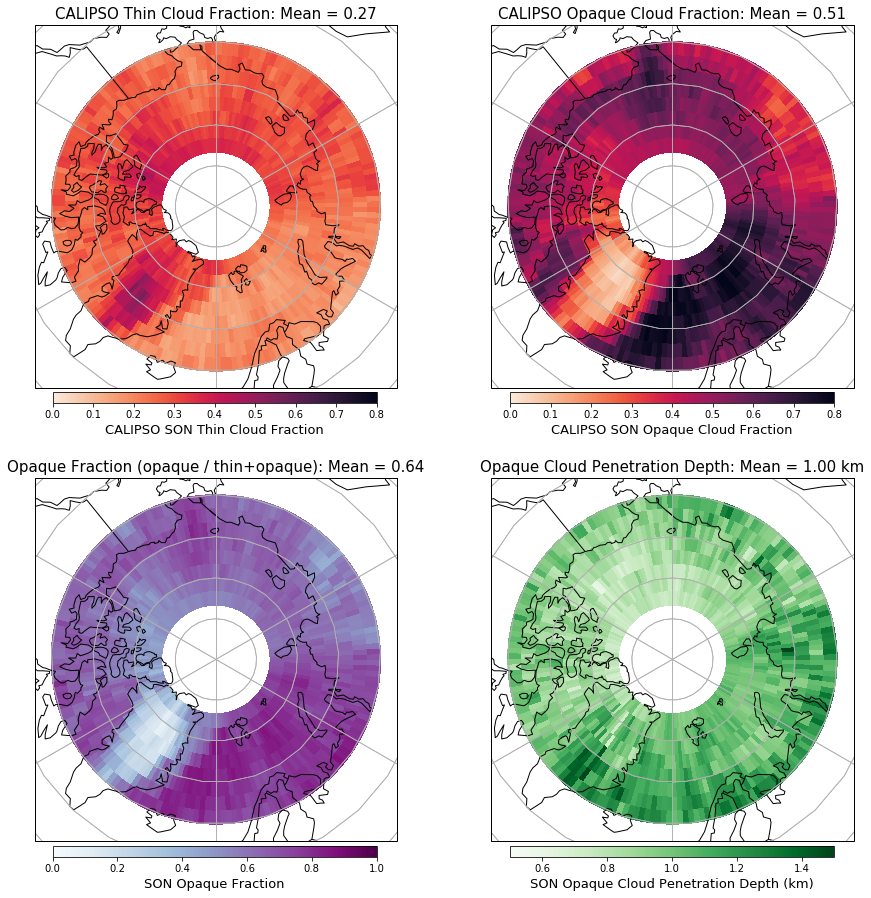

In [153]:
fig_SON, axes = sp_map(nrows=2, ncols=2,
                    projection=ccrs.NorthPolarStereo(), figsize=[15,15])
axes = axes.flat

plt.subplots_adjust(hspace=0.25)

# Calculate Arctic Averages:
cltcalipso_thin_ArcAvg = masked_average(cltcalipso_thin_SON,
                                        weights=cltcalipso_thin_SON['cell_weight'],
                                        mask=cltcalipso_thin_SON['lat']<66)
cltcalipso_opaque_ArcAvg = masked_average(cltcalipso_opaque_SON,
                                        weights=cltcalipso_opaque_SON['cell_weight'],
                                        mask=cltcalipso_opaque_SON['lat']<66)
calipso_opaque_frac_ArcAvg = masked_average(calipso_opaque_frac_SON,
                                        weights=calipso_opaque_frac_SON['cell_weight'],
                                        mask=calipso_opaque_frac_SON['lat']<66)
caliop_depth_ArcAvg = masked_average(caliop_depth_SON,
                                        weights=caliop_depth_SON['cell_weight'],
                                        mask=caliop_depth_SON['lat']<66)

im0 = cltcalipso_thin_SON.plot(ax=axes[0],cmap=sns.cm.rocket_r,transform=ccrs.PlateCarree(),
                              add_colorbar=False, robust=True,vmin=0,vmax=0.8)
axes[0].set_title('CALIPSO Thin Cloud Fraction: Mean = %.2f' % cltcalipso_thin_ArcAvg,fontsize=15)
cax0 = fig_SON.add_axes([0.15,0.53,0.3,0.01])
cbar0 = plt.colorbar(im0,cax=cax0,orientation='horizontal')
cbar0.set_label(label='CALIPSO SON Thin Cloud Fraction',fontsize=13)

im1 = cltcalipso_opaque_SON.plot(ax=axes[1],cmap=sns.cm.rocket_r,transform=ccrs.PlateCarree(),
                              add_colorbar=False, robust=True,vmin=0,vmax=0.8)
axes[1].set_title('CALIPSO Opaque Cloud Fraction: Mean = %.2f' % cltcalipso_opaque_ArcAvg,fontsize=15)
cax1 = fig_SON.add_axes([0.5735,0.53,0.3,0.01])
cbar1 = plt.colorbar(im1,cax=cax1,orientation='horizontal')
cbar1.set_label(label='CALIPSO SON Opaque Cloud Fraction',fontsize=13)

im2 = calipso_opaque_frac_SON.plot(ax=axes[2],cmap='BuPu',transform=ccrs.PlateCarree(),
                              add_colorbar=False, robust=True,vmin=0,vmax=1.0)
axes[2].set_title('Opaque Fraction (opaque / thin+opaque): Mean = %.2f' % calipso_opaque_frac_ArcAvg,fontsize=15)
cax2 = fig_SON.add_axes([0.15,0.11,0.3,0.01])
cbar2 = plt.colorbar(im2,cax=cax2,orientation='horizontal')
cbar2.set_label(label='SON Opaque Fraction',fontsize=13)

im3 = caliop_depth_SON.plot(ax=axes[3],transform=ccrs.PlateCarree(),cmap="Greens",
                              add_colorbar=False,robust=False,extend='neither',vmin=0.5,vmax=1.5)
axes[3].set_title('Opaque Cloud Penetration Depth: Mean = %.2f km' % caliop_depth_ArcAvg,fontsize=15)
cax3 = fig_SON.add_axes([0.5735,0.11,0.3,0.01])
cbar3 = plt.colorbar(im3,cax=cax3,orientation='horizontal')
cbar3.set_label(label='SON Opaque Cloud Penetration Depth (km)',fontsize=13)


lat_lims = [59,90]
for _ax in axes:
    add_map_features(_ax)
#     polarCentral_set_latlim(lat_lims, _ax)

# plt.tight_layout()

In [163]:
to_png(fig_SON,'CALIOP_depth_4panel_SON')

In [77]:
sns.choose_cubehelix_palette(as_cmap=True)

interactive(children=(IntSlider(value=9, description='n_colors', max=16, min=2), FloatSlider(value=0.0, descri…

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


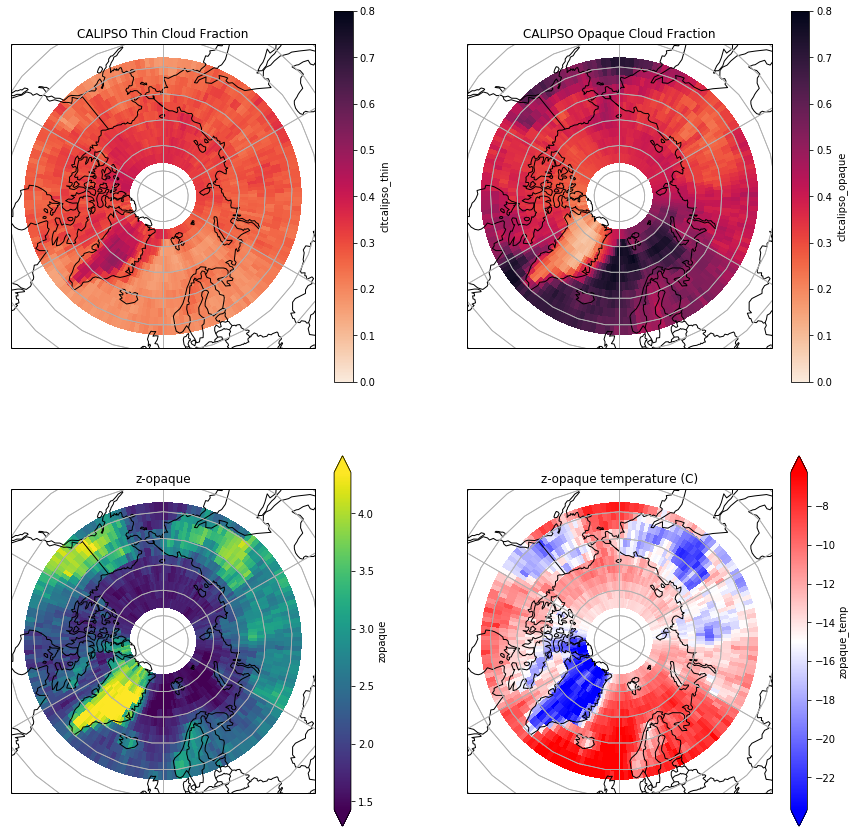

In [74]:
im2 = zopaque_Tavg.plot(ax=axes[2],transform=ccrs.PlateCarree(),
                              add_colorbar=True, robust=True)
axes[2].set_title('z-opaque')

im3 = zopaque_temp_Tavg.plot(ax=axes[3],cmap='bwr',transform=ccrs.PlateCarree(),
                              add_colorbar=True, robust=True)
axes[3].set_title('z-opaque temperature (C)')

for _ax in axes:
    add_map_features(_ax)

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


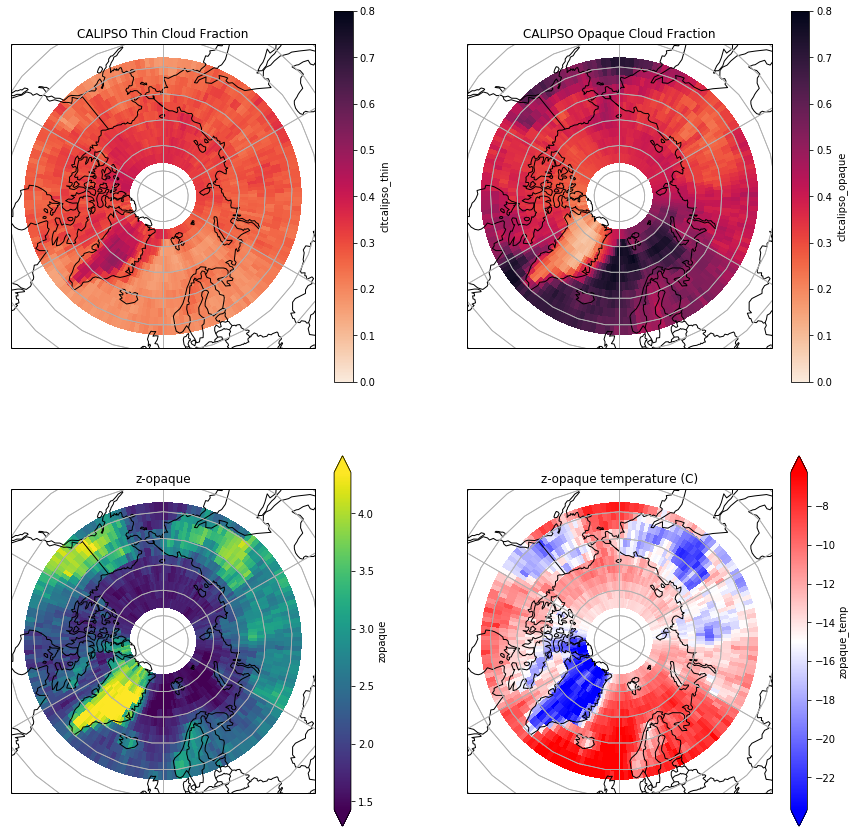

In [74]:
fig, axes = sp_map(nrows=2, ncols=2,
                           projection=ccrs.NorthPolarStereo(), figsize=[15,15])
axes = axes.flat

im0 = cltcalipso_thin_Tavg.plot(ax=axes[0],cmap=sns.cm.rocket_r,transform=ccrs.PlateCarree(),
                              add_colorbar=True, robust=True,vmin=0,vmax=0.8)
axes[0].set_title('CALIPSO Thin Cloud Fraction')

im1 = cltcalipso_opaque_Tavg.plot(ax=axes[1],cmap=sns.cm.rocket_r,transform=ccrs.PlateCarree(),
                              add_colorbar=True, robust=True,vmin=0,vmax=0.8)
axes[1].set_title('CALIPSO Opaque Cloud Fraction')

im2 = zopaque_Tavg.plot(ax=axes[2],transform=ccrs.PlateCarree(),
                              add_colorbar=True, robust=True)
axes[2].set_title('z-opaque')

im3 = zopaque_temp_Tavg.plot(ax=axes[3],cmap='bwr',transform=ccrs.PlateCarree(),
                              add_colorbar=True, robust=True)
axes[3].set_title('z-opaque temperature (C)')

for _ax in axes:
    add_map_features(_ax)

In [69]:
sns.cm.rocket

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


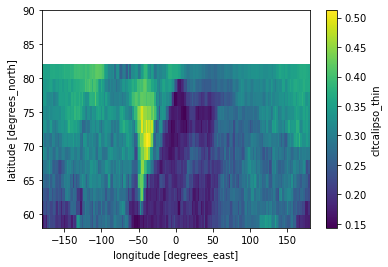

In [35]:
cltcalipso_thin_Tavg.plot()

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


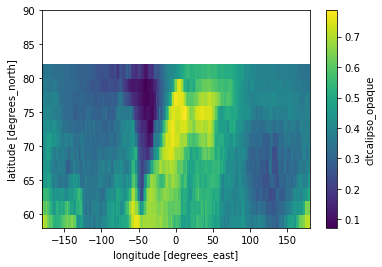

In [38]:
cltcalipso_opaque_Tavg.plot()

In [36]:
opaq_ds_subset

<xarray.Dataset>
Dimensions:                 (latitude: 16, longitude: 180, time: 48)
Coordinates:
  * latitude                (latitude) float32 59.0 61.0 63.0 ... 85.0 87.0 89.0
  * longitude               (longitude) float32 -179.0 -177.0 ... 177.0 179.0
  * time                    (time) datetime64[ns] 2009-06-15T14:04:06.093750016 ... 2013-05-12T22:48:16.875000
Data variables:
    cltcalipso_thin         (time, latitude, longitude) float32 dask.array<chunksize=(1, 16, 180), meta=np.ndarray>
    cltcalipso_opaque       (time, latitude, longitude) float32 dask.array<chunksize=(1, 16, 180), meta=np.ndarray>
    zopaque_se              (time, latitude, longitude) float32 dask.array<chunksize=(1, 16, 180), meta=np.ndarray>
    zopaque                 (time, latitude, longitude) float32 dask.array<chunksize=(1, 16, 180), meta=np.ndarray>
    calipso_notopaque       (time, latitude, longitude) float32 dask.array<chunksize=(1, 16, 180), meta=np.ndarray>
    nsidc                   (time, latitude, longitude) float32 dask.array<chunksize=(1, 16, 180), meta=np.ndarray>
    cltcalipso_thin_temp    (time, latitude, longitude) float32 dask.array<chunksize=(1, 16, 180), meta=np.ndarray>
    cltcalipso_opaque_temp  (time, latitude, longitude) float32 dask.array<chunksize=(1, 16, 180), meta=np.ndarray>
    zopaque_temp            (time, latitude, longitude) float32 dask.array<chunksize=(1, 16, 180), meta=np.ndarray>
    cltcalipso_thin_z_se    (time, latitude, longitude) float32 dask.array<chunksize=(1, 16, 180), meta=np.ndarray>
    cltcalipso_opaque_z_se  (time, latitude, longitude) float32 dask.array<chunksize=(1, 16, 180), meta=np.ndarray>
    cltcalipso_thin_z       (time, latitude, longitude) float32 dask.array<chunksize=(1, 16, 180), meta=np.ndarray>
    cltcalipso_opaque_z     (time, latitude, longitude) float32 dask.array<chunksize=(1, 16, 180), meta=np.ndarray>
    cltcalipso_thin_emis    (time, latitude, longitude) float32 dask.array<chunksize=(1, 16, 180), meta=np.ndarray>
Attributes:
    Description:               GOCCP_OPAQ_Map_file
    Date:                      
    Version:                   Prog_version
    Authors:                   Rodrigo GUZMAN, Gregory CESANA, Helene CHEPFER...
    Scientific_contact:        helene.chepfer@lmd.polytechnique.fr
    Technical_support:         rodrigo.guzman@lmd.polytechnique.fr
    Creationdate:              20180413
    Website:                   http://climserv.ipsl.polytechnique.fr/cfmip-ob...
    References:                Guzman et al., 2017, Direct atmosphere opacity...
    history:                   Thu Apr 26 01:13:51 2018: ncra -O /bdd/CFMIP/C...
    NCO:                       "4.5.2"
    nco_openmp_thread_number:  1